In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

ITER = 100
BATCH = 10000
RANGE = 8

In [2]:
# Data generate function
def real_distribution_sample(N):
    samples = np.random.normal(4, 0.5, N)
    samples.sort()
    return samples

def fake_sample(rng, N):
    return np.linspace(-rng, rng, N) + np.random.random(N) * 0.01

In [3]:
# Some helper function to create the model
def linear(x, output_dim, scope=None, stddev=1.0):
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [x.get_shape().as_list()[1], output_dim], initializer=tf.random_normal_initializer(stddev=stddev))
        b = tf.get_variable('b', [output_dim], initializer=tf.constant_initializer(0.0))
        return tf.matmul(x, w) + b

def generator(x, h_dim):
    h0 = tf.nn.tanh(linear(x, h_dim * 2, 'g0'))
    h1 = tf.nn.tanh(linear(h0, h_dim * 2, 'g1'))
    h2 = linear(h1, 1, 'g2')
    return h2

def discrimiator(x, h_dim):
    h0 = tf.tanh(linear(x, h_dim * 2, 'd0'))
    h1 = tf.tanh(linear(h0, h_dim * 2, 'd1'))
    h2 = tf.sigmoid(linear(h1, 1, 'd2'))
    return h2

In [4]:
with tf.variable_scope('Dpre'):
    data = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    label = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    dis_pre = discrimiator(data, 20)

batch_pre = tf.Variable(0)
dis_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Dpre')
loss_pre = tf.reduce_mean(tf.square(dis_pre - label))
opt_pre = tf.train.GradientDescentOptimizer(0.01).minimize(loss_pre, global_step=batch_pre, var_list=dis_pre_params)

In [5]:
with tf.variable_scope('Gen'):
    fake_x = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    gen = generator(fake_x, 20)

with tf.variable_scope('Dis') as scope:
    x = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    dis1 = discrimiator(x, 20)
    scope.reuse_variables()
    dis2 = discrimiator(gen, 20)

batch_d = tf.Variable(0)
dis_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Dis')
loss_d = tf.reduce_mean(- tf.log(dis1) - tf.log(1-dis2))
opt_d = tf.train.GradientDescentOptimizer(0.001).minimize(loss_d, global_step=batch_d, var_list=dis_params)

batch_g = tf.Variable(0)
gen_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Gen')
loss_g = tf.reduce_mean(- tf.log(dis2))
opt_g = tf.train.GradientDescentOptimizer(0.001).minimize(loss_g, global_step=batch_g, var_list=gen_params)

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

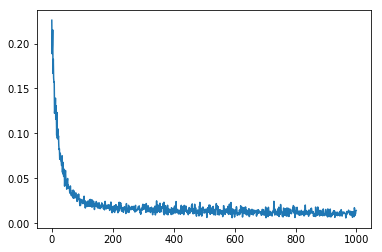

In [7]:
from scipy.stats import norm

pre_losses = []
for i in range(1000):
    d = (np.random.random(BATCH) - 0.5) * 10.0
    y = norm.pdf(d, loc=4, scale=0.5)
    pre_loss, _ = sess.run([loss_pre, opt_pre], feed_dict={data: np.reshape(d, (BATCH, 1)), label: np.reshape(y, (BATCH, 1))})
    pre_losses.append(pre_loss)
plt.plot(pre_losses)
plt.show()

In [8]:
print(len(dis_pre_params))
print(len(dis_params))
weightsD = sess.run(dis_pre_params)
for i, v in enumerate(dis_params):
    sess.run(v.assign(weightsD[i]))

6
6


In [12]:
# Training step
for i in range(0, ITER):
    fake = fake_sample(RANGE, BATCH)
    real = real_distribution_sample(BATCH)
    
    dis_loss, _ = sess.run([loss_d, opt_d], feed_dict={fake_x: np.reshape(fake, (BATCH, 1)), x: np.reshape(real, (BATCH, 1))})
    gen_loss, _ = sess.run([loss_g, opt_g], feed_dict={fake_x: np.reshape(fake, (BATCH, 1))})
    
#     if i % 10 == 0:
    print("Discriminator loss: {}, generator loss: {}".format(dis_loss, gen_loss))

Discriminator loss: 0.5138604640960693, generator loss: 1.571937084197998
Discriminator loss: 0.5121248364448547, generator loss: 1.5736943483352661
Discriminator loss: 0.5104954838752747, generator loss: 1.5747476816177368
Discriminator loss: 0.509476363658905, generator loss: 1.5762693881988525
Discriminator loss: 0.5079208016395569, generator loss: 1.5781244039535522
Discriminator loss: 0.5062747001647949, generator loss: 1.579160213470459
Discriminator loss: 0.5042393803596497, generator loss: 1.5812785625457764
Discriminator loss: 0.502372145652771, generator loss: 1.5827596187591553
Discriminator loss: 0.5010019540786743, generator loss: 1.5841306447982788
Discriminator loss: 0.5001207590103149, generator loss: 1.584907054901123
Discriminator loss: 0.49860331416130066, generator loss: 1.585955023765564
Discriminator loss: 0.49694424867630005, generator loss: 1.5879695415496826
Discriminator loss: 0.495042622089386, generator loss: 1.590204119682312
Discriminator loss: 0.493584901

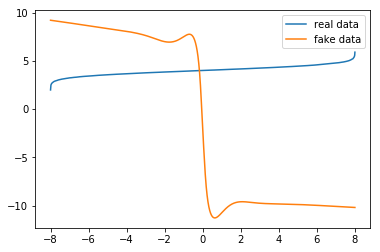

In [13]:
import matplotlib.pyplot as plt
# Test step
real = real_distribution_sample(BATCH)
fake = sess.run(gen, feed_dict={fake_x: np.reshape(np.linspace(-RANGE, RANGE, BATCH), (BATCH, 1))})
plt.plot(np.linspace(-RANGE, RANGE, BATCH), real, label='real data')
plt.plot(np.linspace(-RANGE, RANGE, BATCH), fake, label='fake data')
plt.legend()
plt.show()